# Autotrader analysis
Data source: [www.autotrader.co.uk](https://www.autotrader.co.uk/)
 
This is an analysis of used car adverts found on AutoTrader.co.uk.  Data from each advert was web-scraped from in order to explore how selling price is influenced by factors such as mileage, age, features etc.  The end result is to build a model to help me decide an appropriate selling price for my own car.
 
Webscraper was written using requests + beautifulsoup4.  Code at [github.com/adin786/autotrader-analysis](https://github.com/adin786/autotrader-analysis)
 
### Table of Contents
 
### Assumptions
- Autotrader doesn't know the eventual sale price, only the advertised price.  So this analysis doesn't exactly look at the market price that buyers are willing to pay, instead it is the price that my car could be advertised at in order to match similarly specced cars.
- I only looked at high level summary data from the main search page not each adverts detail page.
 
### Prerequisites
This notebook does not do any web scraping, and requires the data to be available already in a .csv file.  I have not uploaded my scraped dataset to ensure no violation of AuyoTrader terms of service. 
 
To replicate this analysis the following must be completed:
- Using the search function of the AutoTrader website, adverts were filtered for `make='Audi'` and `model='A6'`.  
- The search URL was copied and used as an input to the self-made webscraper code from the above repo.
- The webscraper was configured to loop over the first 100 pages of adverts, and store them in a .csv file.  
- The same process could be easily repeated for any other search URL, for example with a different vehicle make.  
- I chose not to scrape data for any and all vehicle brands as I was only interested in Audi A6 models.  I also chose to only scrape from the main search page rather than each individual advert page.  I found there was enough summary data there for a reasonable analysis. And this saved time and kept my request load on the servers low.

# Load data

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

# Import from csv
path = os.path.join('drive','MyDrive','Data', 'autotrader')
df = pd.read_csv(os.path.join(path,'scraped_autotrader.csv'))

In [ ]:
# Preview imported csv data
df.head()

,advert_id,attention_grabber,condition_value,description_full,detail_ad,distance_value,good_great_value,has_finance,id,image_count,is_allocated_stock,is_franchise_approved,is_group_stock,is_manufacturer_approved,is_multi_location_advert,is_network_stock,is_virtual_stock,key_spec_list_ad,price,search_results_advert_card,seller_location,seller_private_trade,time_of_scrape,title_ad,title_full
0,202103290721220,"Full Leather, Black Interior",NaN,skip,2.0 TDI e S line 4dr,35 miles,noanalysis,True,202103290721220,12,False,False,False,False,False,False,False,"['2010 (10 reg)', 'Saloon', '88,126 miles', '2...","£5,490",NaN,edinburgh,Private seller,2021-04-08 00:38:08.537902,Audi A6 Saloon,skip
1,202103250566697,1 Private Owner + 1 Company,NaN,skip,2.0 Sport 4dr,183 miles,noanalysis,False,202103250566697,95,False,False,False,False,False,False,False,"['2003 (03 reg)', 'Saloon', '82,154 miles', '2...","£2,000",NaN,5.0,Woodside Car Sales,2021-04-08 00:38:08.590687,Audi A6 Saloon,skip
2,202003248731394,Stunning Bespoke A6 C6 4.2LTR,NaN,skip,4.2 S line quattro 4dr,3 miles,noanalysis,False,202003248731394,20,False,False,False,False,False,False,False,"['2005 (54 reg)', 'Saloon', '121,000 miles', '...","£5,990",NaN,glasgow,Private seller,2021-04-08 00:38:08.624812,Audi A6 Saloon,skip
3,202102128981053,"Cream Leather Interior, Bose",NaN,skip,2.0 TDI ultra Black Edition S Tronic (s/s) 4dr,10 miles,noanalysis,True,202102128981053,11,False,False,False,False,False,False,False,"['2015 (15 reg)', 'Saloon', '34,500 miles', '2...","£14,490",NaN,glasgow,Private seller,2021-04-08 00:38:08.659050,Audi A6 Saloon,skip
4,202102169143343,Full Service History,NaN,skip,2.0 TDI SE 4dr,13 miles,noanalysis,True,202102169143343,15,False,False,False,False,False,False,False,"['2011 (61 reg)', 'Saloon', '62,242 miles', '2...","£7,995",NaN,falkirk,Private seller,2021-04-08 00:38:08.693502,Audi A6 Saloon,skip


In [ ]:
# Check column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   advert_id                   1100 non-null   int64  
 1   attention_grabber           1019 non-null   object 
 2   condition_value             11 non-null     object 
 3   description_full            1100 non-null   object 
 4   detail_ad                   1100 non-null   object 
 5   distance_value              1100 non-null   object 
 6   good_great_value            1100 non-null   object 
 7   has_finance                 1100 non-null   bool   
 8   id                          1100 non-null   int64  
 9   image_count                 1100 non-null   int64  
 10  is_allocated_stock          1000 non-null   object 
 11  is_franchise_approved       1100 non-null   bool   
 12  is_group_stock              1000 non-null   object 
 13  is_manufacturer_approved    1100 

# Clean data

In [ ]:
# Fill blanks
df.condition_value = df.condition_value.fillna('Blank')

In [ ]:
# Fill blanks in bool features with False as blanks are these features are mostly just for new cars only.
df.is_allocated_stock = df.is_allocated_stock.fillna(False)
df.is_franchise_approved = df.is_franchise_approved.fillna(False)
df.is_group_stock = df.is_group_stock.fillna(False)
df.is_manufacturer_approved = df.is_manufacturer_approved.fillna(False)
df.is_multi_location_advert = df.is_multi_location_advert.fillna(False)
df.is_network_stock = df.is_network_stock.fillna(False)
df.is_virtual_stock = df.is_virtual_stock.fillna(False)

In [ ]:
# Strip '£' and 'miles' for conversion to int later
df.price = df.price.str.replace('£|,','')
df.distance_value = df.distance_value.str.replace(' miles','')

In [ ]:

# Drop column that isn't useful
df = df.drop(['search_results_advert_card'], axis=1)

In [ ]:

# Drop columns for title_full and description_full
# These were placeholders only
df = df.drop(['title_full'], axis=1)

In [ ]:
# Convert columns from strings to proper types
df = df.astype({'advert_id':int,
'attention_grabber': object,
'condition_value': 'category',
'description_full': object,
'detail_ad': object,
'distance_value':int,
'good_great_value':'category',
'has_finance':bool,
'id':int,
'image_count':int,
'is_allocated_stock':bool,
'is_franchise_approved':bool,
'is_group_stock':bool,
'is_manufacturer_approved':bool,
'is_multi_location_advert':bool,
'is_network_stock':bool,
'is_virtual_stock':bool,
'key_spec_list_ad':object,
'price':int,
'seller_location':object,
'seller_private_trade':'category',
'time_of_scrape':'datetime64',
'title_ad':object,
})

In [ ]:
# Check data types converted successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   advert_id                 1100 non-null   int64         
 1   attention_grabber         1019 non-null   object        
 2   condition_value           1100 non-null   category      
 3   description_full          1100 non-null   object        
 4   detail_ad                 1100 non-null   object        
 5   distance_value            1100 non-null   int64         
 6   good_great_value          1100 non-null   category      
 7   has_finance               1100 non-null   bool          
 8   id                        1100 non-null   int64         
 9   image_count               1100 non-null   int64         
 10  is_allocated_stock        1100 non-null   bool          
 11  is_franchise_approved     1100 non-null   bool          
 12  is_group_stock      

 # Remove duplicates

In [ ]:
# check now id is a column of unique values.
print(f'Max value count:      {df.id.value_counts().max()}')
print(f'Total num uniques:    {len(df.id.unique())}')
print(f'Number of rows in df: {len(df)} (should be equal)')

Max value count:      16
Total num uniques:    997
Number of rows in df: 1100 (should be equal)


In [ ]:
# Drop duplicates
df = df.drop_duplicates('id')

In [ ]:
# check now id is a column of unique values.
print(f'Max value count:      {df.id.value_counts().max()}')
print(f'Total num uniques:    {len(df.id.unique())}')
print(f'Number of rows in df: {len(df)} (should be equal)')

Max value count:      1
Total num uniques:    997
Number of rows in df: 997 (should be equal)


# Create new features

## Add year
Extracted from `key_spec_list`

In [ ]:
# Use regex to extract year from spec list
temp = df.key_spec_list_ad.str.strip("'[|]'").str.replace("'",'').str.split(r'(?<!\d),(?<!\d)')
 
r = re.compile('[1-2]\d{3}')
func = lambda x: list(filter(r.match,x))
temp2 = temp.agg(func)
 
func2 = lambda x: r.match(x[0]).group() if len(x)>0 else None
temp3 = temp2.agg(func2)
pd.to_numeric(temp3)
 
df['year'] = temp3.astype(float)

In [ ]:
# Check basic statistics
df.year.describe()

count     985.000000
mean     2014.882234
std         3.251694
min      2003.000000
25%      2013.000000
50%      2016.000000
75%      2017.000000
max      2021.000000
Name: year, dtype: float64

## Add age
Just a subtraction of vehicle year from current date.

In [ ]:
# Placeholder

## Add mileage from features list

In [ ]:
 
# Use regex to extract mileage from spec list
temp = df.key_spec_list_ad.str.strip("'[|]'").str.replace("'",'').str.split(r'(?<!\d),')
temp
 
r = re.compile('.*miles')
func = lambda x: list(filter(r.match,x))
temp2 = temp.agg(func)
 
func2 = lambda x: r.match(x[0]).group() if len(x)>0 else None
temp3 = temp2.agg(func2).str.rstrip('miles').str.strip().str.replace(',','')
 
df['mileage'] = temp3.astype(float)

In [ ]:
# Check basic statistics
df.mileage.describe()

count       985.000000
mean      62597.741117
std       39241.372656
min          25.000000
25%       31655.000000
50%       55222.000000
75%       86675.000000
max      239000.000000
Name: mileage, dtype: float64

# Data exploration

It looks like price is correlated strongly with:
- Mileage
- Year (Note to say I should try repeating this once I've made an `'age'` feature)
 
Also some smaller correlation with:
- image_count
- distance_value

In [ ]:
df.corr()['price'].sort_values(ascending=False)

price                       1.000000
year                        0.862108
is_manufacturer_approved    0.441019
is_allocated_stock          0.383357
is_franchise_approved       0.347020
image_count                 0.203862
has_finance                 0.191332
is_multi_location_advert    0.091101
is_group_stock              0.091101
id                         -0.039228
advert_id                  -0.039228
distance_value             -0.334750
mileage                    -0.784722
is_network_stock                 NaN
is_virtual_stock                 NaN
Name: price, dtype: float64

Visualise the correlation matrix over all numerical params (ignore the bools as they are only relevant to new cars)
 
**image_count**
Correlates a bit with year and mileage, which suggests newer, lower mileage cars (which tend to be high-value) also tend to be better presented with loads of photos.
 
**distance_value**

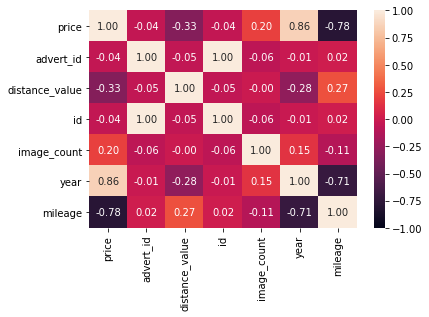

In [ ]:

# Plot a colour coded heat map of Pearson correlation coef
sns.heatmap(df[['price',
'advert_id',
'distance_value',
'id',
'image_count',
'year',
'mileage']].corr(), vmax=1, vmin=-1, annot=True, fmt='.2f');

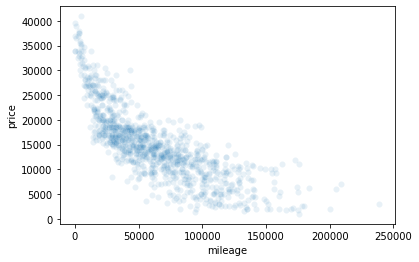

In [ ]:
sns.scatterplot(data=df,x='mileage',y='price', alpha=0.1);

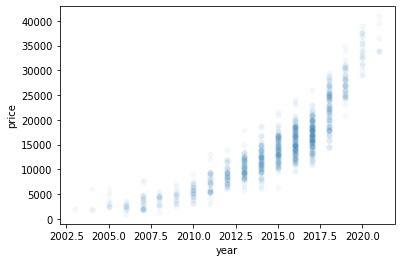

In [ ]:
sns.scatterplot(data=df, x='year', y='price', alpha=0.05);

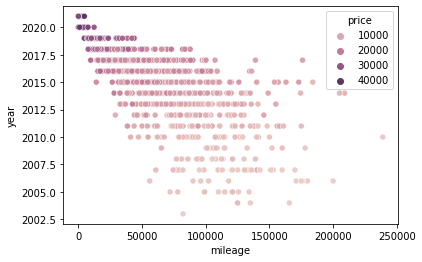

In [ ]:
sns.scatterplot(data=df, x='mileage', y='year', hue='price');

Will definitely need to center this data with setting like StandardScaler, since the values are calendar years, they are miles away from the origin, and some models will behave badly due to this.

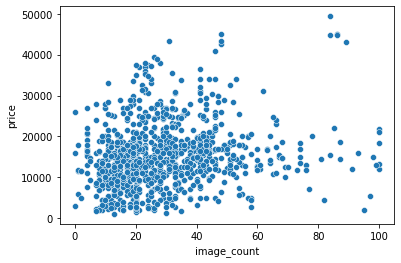

In [ ]:
sns.scatterplot(data=df, x='image_count', y='price');

Not such a strong correlation with image_count, but it had a reasonable Pearson correlation coefficient of 0.2

In [ ]:
df.price

0        5490
1        2000
2        5990
3       14490
4        7995
        ...  
1094    44995
1095     2800
1096    17995
1097     9995
1098    14895
Name: price, Length: 997, dtype: int64

# Create a simple model
Based on only mileage and age

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder 
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score 
from sklearn.metrics import plot_roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

In [ ]:
# train split
X = df[['mileage','year']]
#X = df.drop('price', axis=1)
y = df['price']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression

In [ ]:
# Define a model pipeline
num_features = ['mileage','year']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
linreg = Pipeline([('preprocessor', preprocessor),
                       ('reg', LinearRegression())])

## Evaluate model
Run cross validation and print mean/std-dev
Plot prediction curve over mileage and year features, keeping

In [ ]:
# make a function to speed up model evaluation
def evaluate_reg(reg,reg_name):
   reg.fit(X_train,y_train);
   y_train_pred = reg.predict(X_train)
   y_test_pred = reg.predict(X_test)
   cv_scores = cross_val_score(reg,X_train,y_train)
 
   # Generate a little report
   print(f'model-name:.  {reg_name}')
   print(f'cv-scores:.   {cv_scores}')
   print(f'cv-mean:      {cv_scores.mean():.3f}')
   print(f'cv-stdev:     {cv_scores.std():.3f}')
 
   eval_dict = {'cv_mean':cv_scores.mean(),
                'cv_std':cv_scores.std()}
 
   fig, ax = plt.subplots(1,2)
   fig.set_size_inches(13,5)
   reg.fit(X_train,y_train)
   mileage0 = np.linspace(X_train.mileage.min(),X_train.mileage.max(),10)
 
   for q in [0.1,0.25,0.5,0.75,0.9]:
      year0 = X_train.year.quantile(q)*np.ones(len(mileage0))
 
      X0 = pd.DataFrame(np.c_[mileage0,year0],columns=['mileage','year'])
      y0 = reg.predict(X0)
      ax[0].plot(X0.mileage,y0,label=str(q));
 
   ax[0].plot(X_train.mileage,y_train,'.',alpha=0.2);
   ax[0].set_xlabel('mileage');
   ax[0].set_ylabel('price');
   ax[0].legend();
 
   year1 = np.linspace(X_train.year.min(),X_train.year.max(),10)
 
   for q in [0.1,0.25,0.5,0.75,0.9]:
     mileage1 = X_train.mileage.quantile(q)*np.ones(len(year1))
     X1 = pd.DataFrame(np.c_[mileage1,year1],columns=['mileage','year'])
     y1 = reg.predict(X1)
     plt.plot(X1.year,y1,label=str(q));
 
   ax[1].plot(X_train.year,y_train,'.',alpha=0.2);
   ax[1].set_xlabel('year');
   ax[1].set_ylabel('price');
   ax[1].legend();
   
   return eval_dict

model-name:.  linreg basic
cv-scores:.   [0.73664136 0.75485285 0.66111552 0.68931985 0.74425227]
cv-mean:      0.717
cv-stdev:     0.036


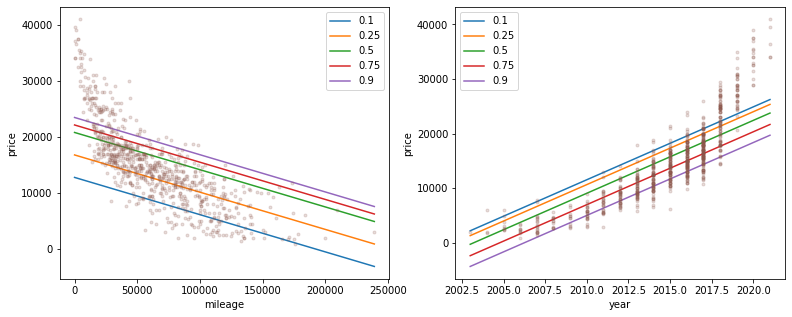

In [ ]:
evaluate_reg(linreg,
             'linreg basic');

# Linear reg with poly features

In [ ]:
# Define a model pipeline
num_features = ['mileage','year']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
linregpoly = Pipeline([('preprocessor', preprocessor),
                       ('reg', LinearRegression())])

model-name:.  linreg with poly features
cv-scores:.   [0.79037821 0.83632692 0.69423435 0.74137143 0.83001843]
cv-mean:      0.778
cv-stdev:     0.054


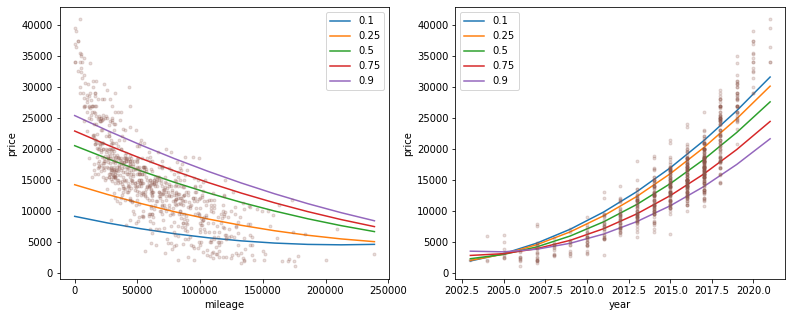

In [ ]:
evaluate_reg(linregpoly,
             'linreg with poly features');

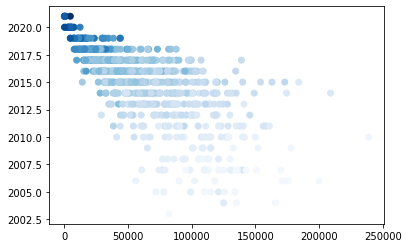

In [ ]:
plt.scatter(X_train.mileage,X_train.year,c=y_train,cmap='Blues');

# knn

In [ ]:
# Define a model pipeline
num_features = ['mileage','year']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
knnreg = Pipeline([('preprocessor', preprocessor),
                       ('knn', KNeighborsRegressor())])

model-name:.  knn basic
cv-scores:.   [0.8579051  0.75903078 0.80745591 0.91856881 0.91691092]
cv-mean:      0.852
cv-stdev:     0.062


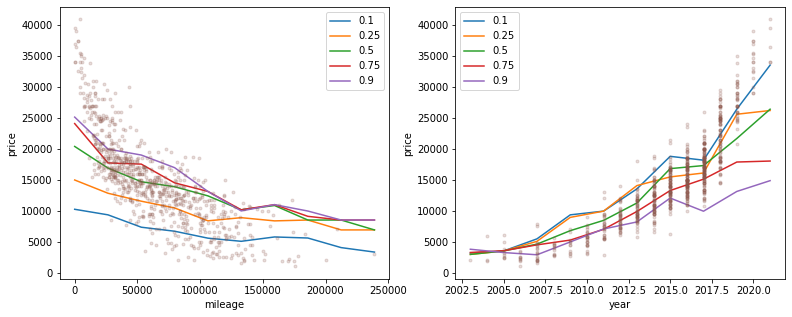

In [ ]:
evaluate_reg(knnreg,
             'knn basic');

# Knn with poly features

In [ ]:
# Define a model pipeline
num_features = ['mileage','year']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
knnregpoly = Pipeline([('preprocessor', preprocessor),
                       ('reg', KNeighborsRegressor())])

model-name:.  knn with poly features
cv-scores:.   [0.8521858  0.74726192 0.80810063 0.91715384 0.91300708]
cv-mean:      0.848
cv-stdev:     0.064


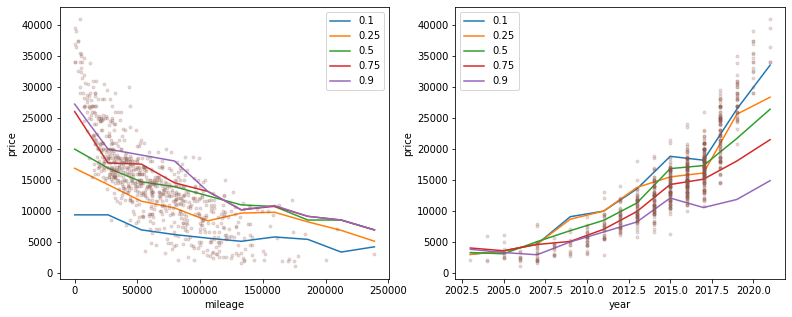

In [ ]:
evaluate_reg(knnregpoly,
             'knn with poly features');

# svm

In [ ]:
# Define a model pipeline
num_features = ['mileage','year']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                       #     ('poly', PolynomialFeatures(degree=2))
])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
svmreg = Pipeline([('preprocessor', preprocessor),
                   ('reg', LinearSVR())])

model-name:.  Linear SVR
cv-scores:.   [-4.01023722 -4.45273404 -3.60858292 -3.59047243 -3.04883503]
cv-mean:      -3.742
cv-stdev:     0.469


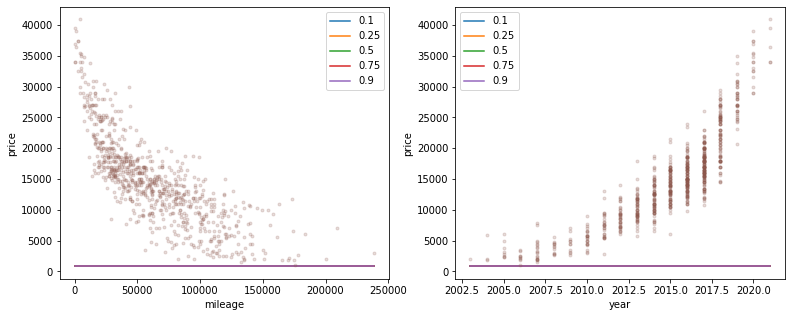

In [ ]:
evaluate_reg(svmreg,'Linear SVR');

# SVR alternative

In [ ]:
from sklearn.svm import SVR
# Define a model pipeline
num_features = ['mileage','year']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2))
])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
svrreg = Pipeline([('preprocessor', preprocessor),
                   ('reg', SVR(epsilon=0.000001))])

model-name:.  SVR alternative
cv-scores:.   [ 0.0090875   0.00940883 -0.00571832 -0.01379916  0.00313093]
cv-mean:      0.000
cv-stdev:     0.009


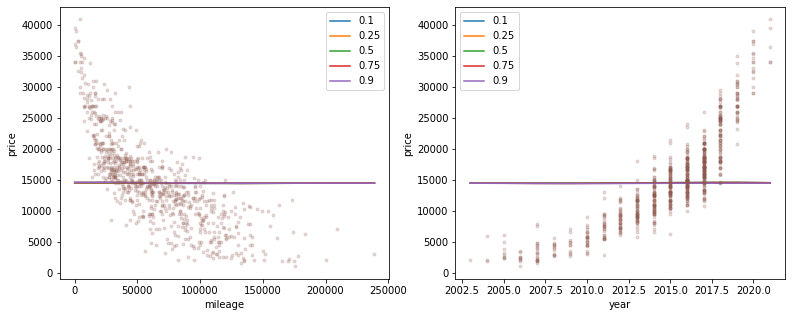

In [ ]:
evaluate_reg(svrreg,'SVR alternative');

CPU times: user 1.3 s, sys: 90.2 ms, total: 1.39 s
Wall time: 36.9 s
best params:    {'reg__C': 100000, 'reg__gamma': 0.01}
model-name:.  svr tuned
cv-scores:.   [0.7998473  0.8768054  0.68404227 0.749821   0.85335003]
cv-mean:      0.793
cv-stdev:     0.070


{'cv_mean': 0.7927731993889529, 'cv_std': 0.06992612103615013}

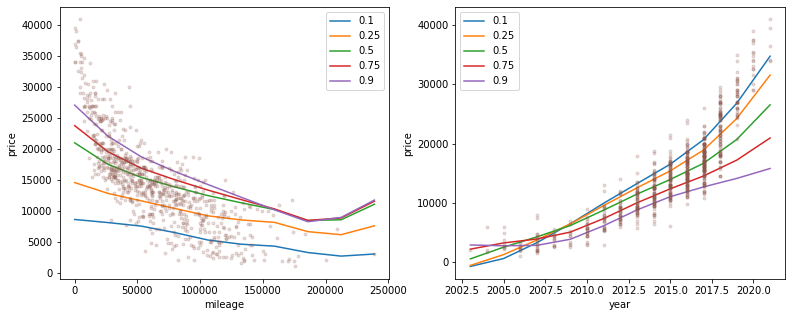

In [ ]:
param_grid = {'reg__C':[0.1,10,100,1000,10000,100000,1000000],
              'reg__gamma':[0.001,0.01,0.1,1,10]}
 
svrgrid = GridSearchCV(svrreg,param_grid,n_jobs=-1)
%time svrgrid.fit(X_train,y_train)
print(f'best params:    {svrgrid.best_params_}')
#print(svrgrid.best_score_)
evaluate_reg(svrgrid.best_estimator_,'svr tuned')

# tree regression

# Rand forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
 
# Define a model pipeline
num_features = ['mileage','year']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler()),
                       #     ('poly', PolynomialFeatures(degree=2))
])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
forestreg = Pipeline([('preprocessor', preprocessor),
                   ('reg', RandomForestRegressor())])

model-name:.  Forest
cv-scores:.   [0.85240734 0.8192984  0.83792582 0.89516744 0.90381657]
cv-mean:      0.862
cv-stdev:     0.033


{'cv_mean': 0.8617231148557936, 'cv_std': 0.032690467830652103}

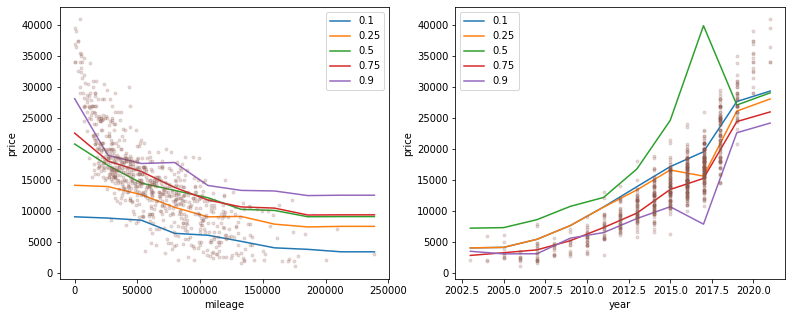

In [ ]:
evaluate_reg(forestreg,'Forest')

### Quick investigation to see why mods predict a shallow line Vs mileage.

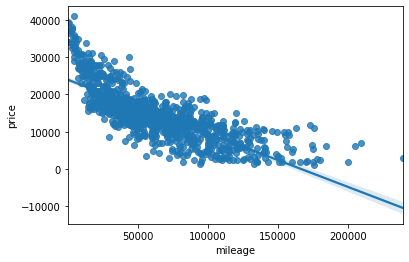

In [ ]:
sns.regplot(data=df,x='mileage',y='price')

In [ ]:
# Define a model pipeline
num_features = ['mileage']
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])
 
preprocessor = ColumnTransformer([('nums', num_transformer, num_features)],
                                 remainder='drop')
 
linreg = Pipeline([('preprocessor', preprocessor),
                       ('reg', LinearRegression())])

model-name:.  linreg basic
cv-scores:.   [0.60216415 0.60308503 0.45518579 0.52176248 0.5569312 ]
cv-mean:      0.548
cv-stdev:     0.055


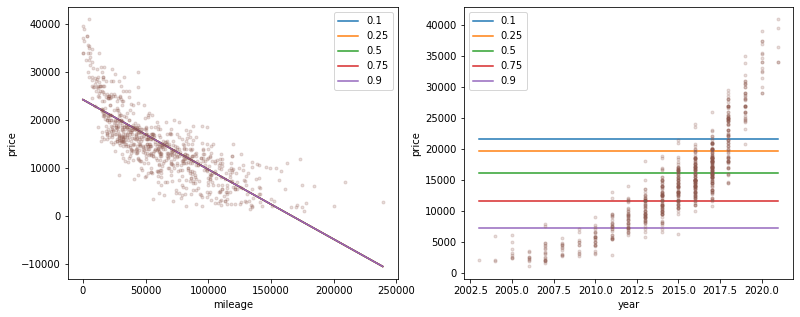

In [ ]:
evaluate_reg(linreg,
             'linreg basic');

Ok so linear model is just behaving differently when extra feature.  Let's continue to try other models only using these 2 features, adding complexity later on if needed.

In [ ]:
testprep = SimpleImputer()
X2 = testprep.fit_transform(X_train)
 
testprep2 = StandardScaler()
X3 = testprep2.fit_transform(X2)
 
testsvr = SVR()
testsvr.fit(X3,y_train)
 
testsvr.predict(X3)
#y_train.values
 
#evaluate_reg(testsvr,'test')

array([14419.1243611 , 14315.97849864, 14379.97383532, 14487.05663906,
       14305.94871335, 14299.66909355, 14629.10423493, 14436.62498386,
       14462.03569567, 14628.11906875, 14328.16712175, 14641.87658418,
       14422.97410258, 14655.12319485, 14409.82331343, 14657.43954868,
       14608.39968175, 14285.15984022, 14391.19442029, 14411.67918162,
       14350.01199151, 14295.57734532, 14333.56412512, 14522.88761906,
       14281.64132993, 14562.27364806, 14463.44886734, 14449.2520299 ,
       14655.7100304 , 14656.92311942, 14643.99365799, 14633.316735  ,
       14298.80093052, 14640.51201562, 14554.39803354, 14488.80774896,
       14555.98068193, 14374.56388082, 14574.6075504 , 14575.52988765,
       14586.78948016, 14631.69922546, 14285.43526672, 14339.71467481,
       14322.75030542, 14316.39773138, 14609.85503659, 14406.67644202,
       14646.34363319, 14593.70012412, 14536.12453301, 14276.75270693,
       14642.91888495, 14323.01479804, 14374.69121612, 14644.42686272,
      